In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [2]:
from utils import *
from data import *
from layers import *
from models import *

In [3]:
limit_gpus()
set_gpu(0)

In [4]:
dataset = "mnist"
ds_train, ds_test, ds_info = load_dataset(dataset, 128)

input_shape = ds_info.features['image'].shape
num_classes = ds_info.features['label'].num_classes

In [5]:
input_shape

(28, 28, 1)

In [6]:
head = keras.models.load_model("ae_conv_head.h5")
#head.compile()


inv_head = keras.models.load_model("ae_inv_head.h5")
#inv_head.compile()


In [7]:
n_d = 1000
n_hidden = 100

image_input = keras.Input(shape=input_shape)
class_input = keras.Input(shape=(n_d,))

In [8]:
imo = IrisModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100.0, bind=False)
#opt = keras.optimizers.Adagrad()
imo.compile(optimizer="rmsprop")
#vim.train(ds_train, 6, 200)

In [9]:
def grs(n_s):
    rand_x = imo.random_samples(n_s)
    rand_y = imo.random_samples(n_s)
    rand_h = imo.forward(rand_x, rand_y)
    rand_data = (rand_x, rand_y, rand_h, rand_h, rand_h)
    return rand_data

In [10]:
imo.save_weights("initvals.k")

In [11]:
#r_loss = imo.train(grs(10000), 20)

In [12]:
#plt.plot(r_loss)

In [13]:
data = imo.generate_external(ds_train, True)

In [14]:
losses = imo.train(data, epochs=2, energy=False)

Training loss [0.9982108 1.0025427 1.0021088 1.0021522]
Training loss [0.21419907 0.18385385 0.18750834 0.18365662]
Training loss [0.20923592 0.18155771 0.19644555 0.18185031]
Training loss [0.17980024 0.16233785 0.1887658  0.16362521]
Training loss [0.18751138 0.16440272 0.19226593 0.16547267]
Training loss [0.17453092 0.15709728 0.19100475 0.15828249]
Training loss [0.17147109 0.15000854 0.18598883 0.15133663]
Training loss [0.18229051 0.15733501 0.19566366 0.15722555]
Training loss [0.16362162 0.14505273 0.18810764 0.14534047]
Training loss [0.17240672 0.14879014 0.19182569 0.1504066 ]


In [15]:
dpi = 100

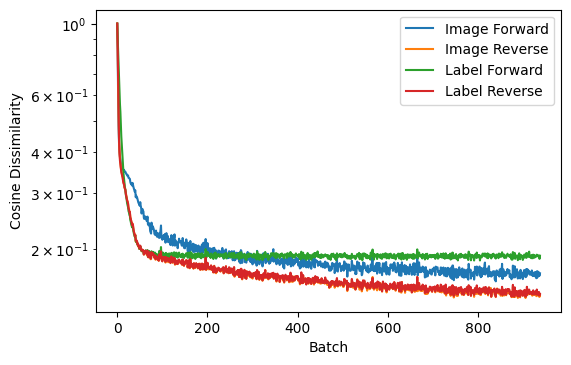

In [16]:
plt.figure(dpi=dpi)
plt.semilogy(losses[:,0], label="Image Forward")
plt.semilogy(losses[:,1], label="Image Reverse")
plt.semilogy(losses[:,2], label="Label Forward")
plt.semilogy(losses[:,3], label="Label Reverse")
plt.xlabel("Batch")
plt.ylabel("Cosine Dissimilarity")
plt.legend()

In [17]:
imo.accuracy(ds_test, False, False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.982>,)

In [18]:
conf = imo.accuracy(ds_test, True)


Text(0, 0.5, 'Guessed Label')

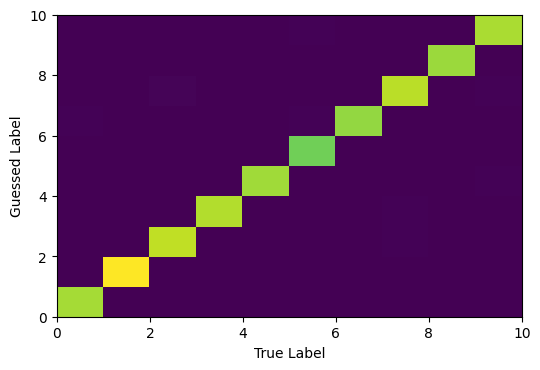

In [19]:
plt.figure(dpi=dpi)
plt.pcolor(conf[0])
plt.xlabel("True Label")
plt.ylabel("Guessed Label")

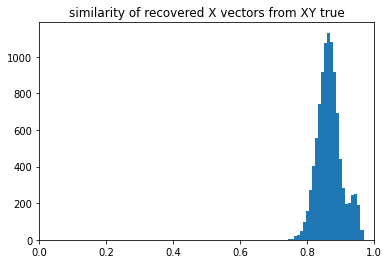

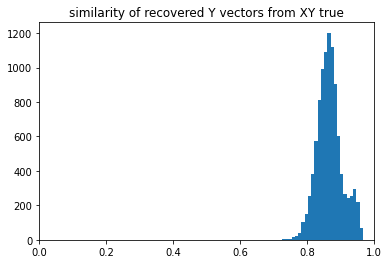

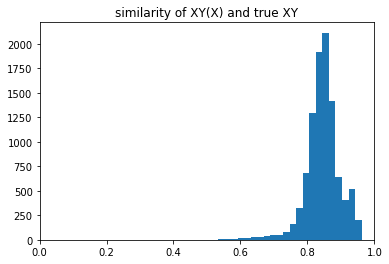

In [20]:
plotinternals(imo, ds_test)

In [21]:
#generation test

In [22]:
r_imgs = imo.reconstruct(data[3][0:32,...])

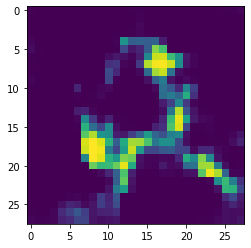

In [23]:
plt.imshow(r_imgs[0,...])

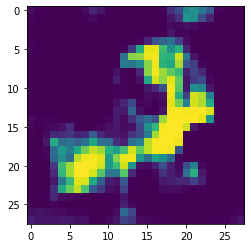

In [24]:
plt.imshow(r_imgs[1,...])

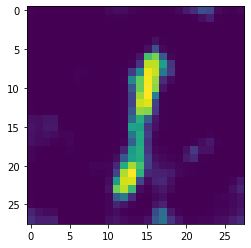

In [25]:
plt.imshow(r_imgs[2,...])

In [53]:
imo.label_encoder.noisy = True

In [58]:
imo.label_encoder.noise = 0.10

In [62]:
all_imgs = []
ns = 5

for i in range(10):
    lbls = imo.label_encoder(i*tf.ones(ns, dtype=tf.int32))
    syms = imo.label_ch.forward(lbls)
    syms = imo.image_ch.reverse(syms)
    feats = imo.img_encoder.reverse(syms)
    imgs = imo.inv_head(feats)
    
    all_imgs.append(imgs.numpy())

In [76]:
ax[0,1].get_xaxis()

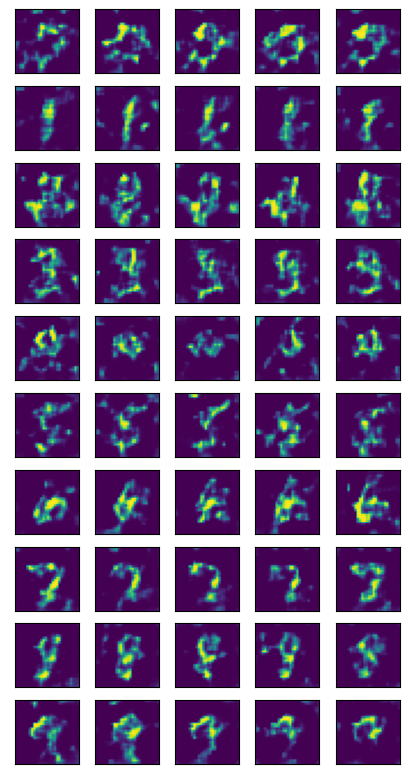

In [77]:
fix, ax = plt.subplots(10, 5, dpi=dpi, figsize=(5,10))

for c in range(10):
    for i in range(5):
        ax[c,i].imshow(all_imgs[c][i,...])
        ax[c,i].get_xaxis().set_visible(False)
        ax[c,i].get_yaxis().set_visible(False)

In [ ]:
zeros = imo.inv_head(imo.img_encoder.reverse(imo.image_ch.reverse(imo.label_ch.forward(imo.label_encoder(tf.range(0,10))))))

In [31]:
ideal_imgs = imo.inv_head(imo.img_encoder.reverse(imo.image_ch.reverse(imo.label_ch.forward(imo.label_encoder(tf.range(0,10))))))

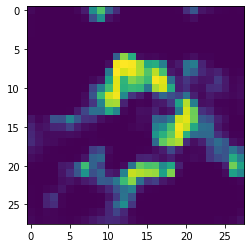

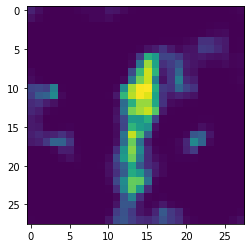

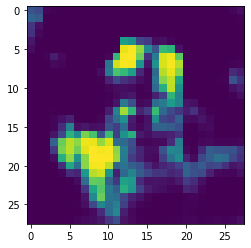

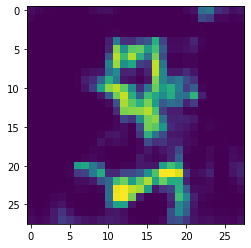

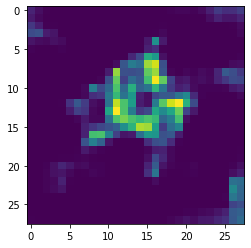

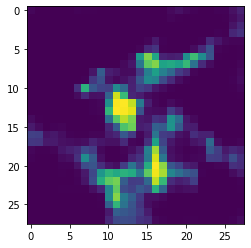

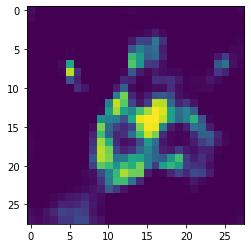

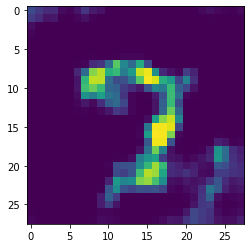

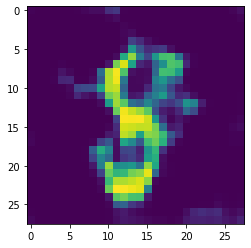

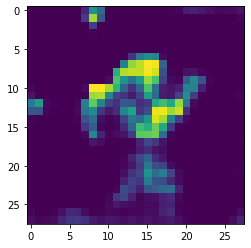

In [32]:
for i in range(10):
    plt.figure()
    plt.imshow(ideal_imgs[i,...])

# retrain from random symbols

In [19]:
r_distill = imo.generate_internal(imo.random_samples(10000), True)

In [20]:
imo_r = IrisModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100.0, bind=False)
#opt = keras.optimizers.Adagrad()
imo_r.compile(optimizer="rmsprop")
#vim.train(ds_train, 6, 200)

In [21]:
imo_r.load_weights("initvals_e.k")

In [22]:
imo_r.train(r_distill, 5)

Training loss [0.9998587 0.8588593 1.0000837 0.8515159]
Training loss [0.9643299 0.6238188 0.9676038 0.6073482]
Training loss [0.94856405 0.44635767 0.9540684  0.4249395 ]
Training loss [0.9257039  0.31509453 0.93508404 0.29345497]
Training loss [0.8864491  0.22231422 0.8988318  0.20522583]


array([[0.9998587 , 0.8588593 , 1.0000837 , 0.8515159 ],
       [0.997509  , 0.8579524 , 0.9992577 , 0.84881514],
       [1.000018  , 0.84930176, 1.0014259 , 0.84367585],
       ...,
       [0.87748295, 0.14902969, 0.87019515, 0.14617138],
       [0.84397554, 0.14961106, 0.826787  , 0.1483692 ],
       [0.55739224, 0.10195561, 0.544076  , 0.1017206 ]], dtype=float32)

In [23]:
imo_r.accuracy(ds_test, False, False)

(<tf.Tensor: shape=(), dtype=float64, numpy=0.094>,)

Text(0, 0.5, 'Guessed Label')

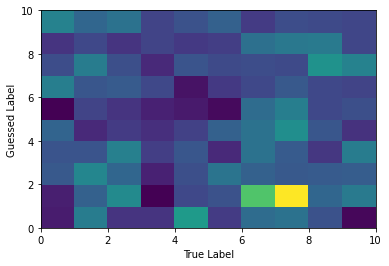

In [24]:
conf2 = imo_r.accuracy(ds_test, True)
plt.pcolor(conf2[0])
plt.xlabel("True Label")
plt.ylabel("Guessed Label")

# retrain from h0 symbols

In [18]:
r_h0, l_h0 = imo.reconstruct_info(5000, 600, optimizer=keras.optimizers.RMSprop(lr=0.005))

[1.0000764 0.998293 ]
[0.30637935 0.29817778]
[0.18416174 0.17645079]
[0.13591139 0.12803376]
[0.11111731 0.10252946]
[0.09604767 0.08665456]


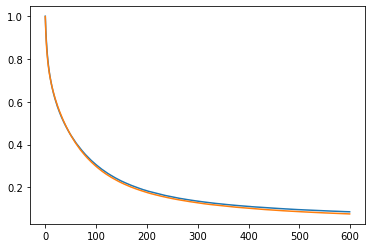

In [19]:
plt.plot(l_h0)

In [76]:
xh0 = imo.image_ch.reverse(r_h0)

In [77]:
yh0 = imo.label_ch.reverse(r_h0)

In [84]:
hx0 = imo.image_ch.forward(xh0)
hy0 = imo.label_ch.forward(yh0)

In [78]:
tf.math.reduce_mean(similarity(xh0, r_h0))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.008961604>

In [79]:
tf.math.reduce_mean(similarity(imo.image_ch.forward(xh0), r_h0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.91096073>

In [80]:
tf.math.reduce_mean(similarity(yh0, r_h0))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.015516867>

In [87]:
tf.math.reduce_mean(similarity(imo.label_ch.forward(yh0), r_h0))

<tf.Tensor: shape=(), dtype=float32, numpy=0.922333>

In [85]:
vsa_loss(hx0, r_h0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.089039244>

In [86]:
vsa_loss(hy0, r_h0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.077667035>

In [88]:
ds_h0 = imo.generate_internal(r_h0, truefwd=False)

In [20]:
imo_rh0 = IrisModel(head, inv_head, ds_info, n_d=n_d, n_hidden=n_hidden, sigma=3.0, overscan=100.0, bind=False)
#opt = keras.optimizers.Adagrad()
imo_rh0.compile(optimizer="rmsprop")
#vim.train(ds_train, 6, 200)

In [21]:
imo_rh0.load_weights("initvals.k")

In [22]:
imo_rh0.img_encoder.norm_symbols.moving_mean = imo.img_encoder.norm_symbols.moving_mean

In [23]:
imo_rh0.img_encoder.norm_symbols.moving_std = imo.img_encoder.norm_symbols.moving_std

In [28]:
ds_h0 = imo.generate_internal(r_h0)

In [29]:
loss2 = imo_rh0.train(ds_h0, epochs=10, energy=False)

Training loss [0.9428468  0.93076825 0.914024   0.95496   ]
Training loss [0.48819438 0.40426254 0.2123715  0.26367444]
Training loss [0.3643096  0.26645464 0.08768685 0.15065324]
Training loss [0.25686744 0.20571376 0.04340191 0.1007308 ]
Training loss [0.19304815 0.17263053 0.02816883 0.08018818]
Training loss [0.15184711 0.14367758 0.02082912 0.06918024]
Training loss [0.12112586 0.12056695 0.01670665 0.06172555]
Training loss [0.09844124 0.10171017 0.01419294 0.05603752]
Training loss [0.08011219 0.0845431  0.01251843 0.05121279]
Training loss [0.06532793 0.07002631 0.01119069 0.04688888]


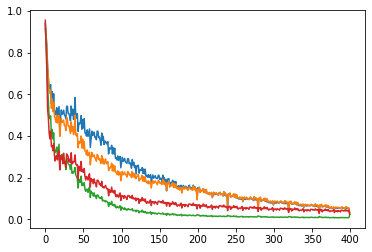

In [30]:
plt.plot(loss2)

In [31]:
conf = imo_rh0.accuracy(ds_test, True, False)

In [34]:
confusion_to_acc(conf[0])

0.9785

In [35]:
samples = np.logspace(1, 3.69, 21)

In [36]:
samples

array([  10.        ,   13.63013006,   18.57804455,   25.32211635,
         34.51437393,   47.04354057,   64.12095766,   87.39769926,
        119.1242008 ,  162.36783505,  221.30947096,  301.64768732,
        411.1497211 ,  560.40241736,  763.83578358, 1041.11810762,
       1419.05752169, 1934.19385862, 2636.33138583, 3593.35396755,
       4897.78819368])

In [42]:

accs = []

for s in samples:
    print(s)
    imo_rh0.load_weights("initvals.k")
    imo_rh0.train(cut(ds_h0, int(s)), epochs=10, energy=False)
    acc = imo_rh0.accuracy(ds_test, False, False)
    accs.append(acc)

10.0
Training loss [0.9627463  0.9462744  0.9226125  0.96154356]
Training loss [0.8221321  0.8109788  0.79614276 0.7797217 ]
Training loss [0.69709164 0.6972567  0.6763312  0.62187445]
Training loss [0.5884718  0.59171903 0.5589805  0.48891625]
Training loss [0.49370766 0.5104653  0.45879006 0.3847412 ]
Training loss [0.41945204 0.43436313 0.37597904 0.30739155]
Training loss [0.35505518 0.37018743 0.30011332 0.24817578]
Training loss [0.30165017 0.3182006  0.24285738 0.21722317]
Training loss [0.2650277  0.27607074 0.19758186 0.18431416]
Training loss [0.23652773 0.24480808 0.16376957 0.1616627 ]
13.630130062078274
Training loss [0.94184977 0.92485106 0.89460754 0.9412692 ]
Training loss [0.8541343  0.8357515  0.81883055 0.84521836]
Training loss [0.7885638 0.7634559 0.7417126 0.7619177]
Training loss [0.7253276  0.6980197  0.68001324 0.68977726]
Training loss [0.667652   0.6453995  0.62270427 0.6324737 ]
Training loss [0.62255186 0.5991881  0.5742037  0.57693887]
Training loss [0.581

Training loss [0.5165864  0.48106542 0.25709778 0.27944365]
Training loss [0.49550477 0.45357537 0.22263828 0.26275843]
Training loss [0.4731091  0.42505682 0.19321333 0.24610458]
Training loss [0.45049766 0.39458707 0.16587627 0.22774898]
Training loss [0.4259029  0.3643025  0.14077081 0.20772746]
763.8357835776907
Training loss [0.93862534 0.93145925 0.9119913  0.95139325]
Training loss [0.6792667  0.6849879  0.55644596 0.43419927]
Training loss [0.59364885 0.57059044 0.38657773 0.339535  ]
Training loss [0.55677474 0.5282701  0.31493115 0.31235808]
Training loss [0.52961576 0.4952215  0.26642525 0.29177067]
Training loss [0.5032428  0.4602205  0.22442695 0.27217585]
Training loss [0.47642684 0.4221887  0.18726933 0.2499638 ]
Training loss [0.44694597 0.3826544  0.15307403 0.22433999]
Training loss [0.4151977  0.3438892  0.12287991 0.19669503]
Training loss [0.38163477 0.30804038 0.09592184 0.16948727]
1041.1181076233397
Training loss [0.9477308  0.9415798  0.92202336 0.9578632 ]
Tra

In [38]:
dpi = 100

In [39]:
original_acc = imo.accuracy(ds_test, False, False)

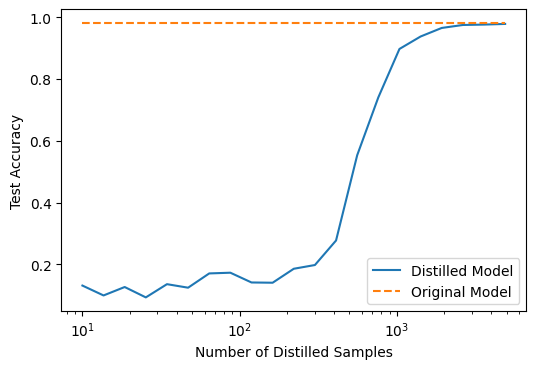

In [43]:
plt.figure(dpi=dpi)
plt.semilogx(samples, accs, label="Distilled Model")
plt.plot(samples, np.ones(len(samples))*original_acc, '--', label="Original Model")
plt.xlabel("Number of Distilled Samples")
plt.ylabel("Test Accuracy")
plt.legend()

In [44]:
fashion_accs = [[0.0906],
       [0.0821],
       [0.0848],
       [0.0889],
       [0.074 ],
       [0.0786],
       [0.096 ],
       [0.1016],
       [0.1044],
       [0.1261],
       [0.1224],
       [0.1792],
       [0.263 ],
       [0.4536],
       [0.5524],
       [0.6766],
       [0.7364],
       [0.7816],
       [0.8266],
       [0.8425],
       [0.8468]]

In [48]:
fashion_original  = 0.8757

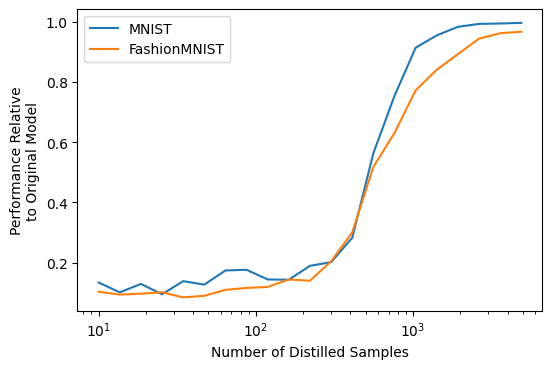

In [49]:
plt.figure(dpi=dpi)
plt.semilogx(samples, np.array(accs)/original_acc, label="MNIST")
plt.semilogx(samples, np.array(fashion_accs)/fashion_original, label="FashionMNIST")
plt.xlabel("Number of Distilled Samples")
plt.ylabel("Performance Relative\nto Original Model")
plt.legend()

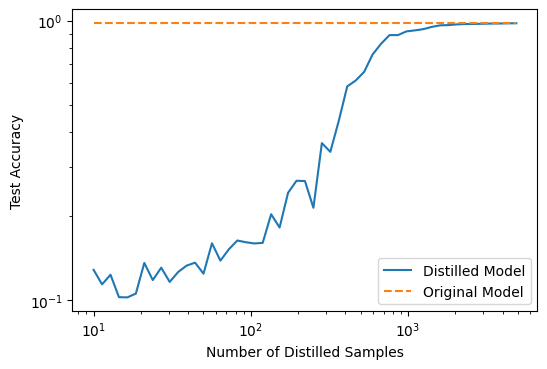

In [161]:
plt.figure(dpi=dpi)
plt.loglog(samples, accs, label="Distilled Model")
plt.plot(samples, np.ones(len(samples))*original_acc, '--', label="Original Model")
plt.xlabel("Number of Distilled Samples")
plt.ylabel("Test Accuracy")
plt.legend()

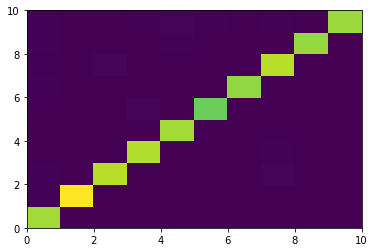

In [128]:
plt.pcolor(conf[0])

In [100]:
ims0, lbls0 = next(iter(ds_test))

In [103]:
aa1 = imo.convert_img(ims0)

In [123]:
aa2 = imo_rh0.convert_img(ims0)

In [110]:
imo.head

In [111]:
imo_rh0.head

In [91]:
np.all(imo.img_encoder.weights[0].numpy() == imo_rh0.img_encoder.weights[0].numpy())

True

In [117]:
imo.img_encoder.norm_symbols.moving_mean

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.05760447], dtype=float32)>

In [118]:
imo.img_encoder.norm_symbols.moving_std

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.073714], dtype=float32)>

In [112]:
imo.img_encoder

In [111]:
imo_rh0.head

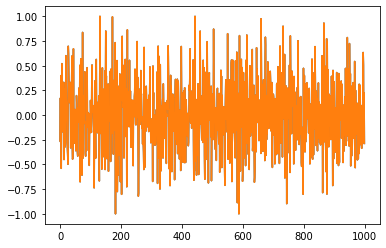

In [124]:
plt.plot(aa1[0,:])
plt.plot(aa2[0,:])

In [125]:
aa1 == aa2

<tf.Tensor: shape=(128, 1000), dtype=bool, numpy=
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])>

In [105]:
aa2.shape

TensorShape([128, 1000])

In [99]:
#check symbols between models